# A Quantum Natural Language Approach to Musical Intelligence

*Eduardo Reck Miranda, Richie Yeung, Anna Pearson, Konstantinos
Meichanetzidis, and Bob Coecke*

**Cambridge Quantum, Oxford** and **ICCMR, University of Plymouth UK**

In [1]:
# 1. Create LL(1) parse table for our musical context-free grammar

primary_elements = ['p4', 'p5', 'p7', 'p9', 'p1', 'p2', 'p3', 'p6', 'p8']
secondary_elements = ['s1', 's2', 's3', 's4']
tertiary_elements = ['t1', 't2', 't3']
ground_elements = ['g1', 'g2']

basic_rule = ('M', 'E2')
compo_rule = ('E3', 'S', 'S')
motif_rule = ('E1', 'E1', 'E1', 'E1')

table = {
    'S': {
        'E3': compo_rule,
        'E1': basic_rule,
    },
    'M': {
        'E1': ('E1', 'E1', 'E1', 'E1')
    },
    'E1': {p: (p,) for p in primary_elements},
    'E2': {s: (s,) for s in secondary_elements},
    'E3': {t: (t,) for t in tertiary_elements}
}

table['S'].update({g: (g,) for g in ground_elements})
table['S'].update({p: basic_rule for p in primary_elements})
table['S'].update({t: compo_rule for t in tertiary_elements})
table['M'].update({p: motif_rule for p in primary_elements})

In [2]:
# 2. Represent the production rules as boxes in discopy

from discopy import Box, Id, Ty, Word

e1 = Ty('e1') # Primary musical element
e2 = Ty('e2') # Seconday musical element
e3 = Ty('e3') # Tertiary musical element
m  = Ty('m')  # Musical motif

# Atomic pregroup types
n = Ty('n')
s = Ty('s')

basic_seq = Box('b_seq', m @ e2, s)
compo_seq = Box('c_seq', e3 @ s @ s, s)
motif = Box('motif', e1 @ e1 @ e1 @ e1, m)

rule_box = {
    basic_rule: basic_seq,
    compo_rule: compo_seq,
    motif_rule: motif
}

rule_box.update({(p,): Word(p, e1) for p in primary_elements})
rule_box.update({(s,): Word(s, e2) for s in secondary_elements})
rule_box.update({(t,): Word(t, e3) for t in tertiary_elements})
rule_box.update({(g,): Word(g, s) for g in ground_elements})

In [3]:
# 3. Implement an LL(1) parser.

def parse(sentence):
    stack = ['S']
    diagram = Id(s)
    while len(sentence) > 0:
        w = sentence[0]
        if len(stack) == 0:
            raise Exception(f'Unexpected token {w}.')
        top = stack.pop(0)
        if top == w:
            sentence.pop(0)
            continue
        if top not in table:
            raise Exception(f'{top} not recognised.')
        if w not in table[top]:
            raise Exception(f'No rule for [{top}, {w}].')
        rule = table[top][w]
        stack = list(rule) + stack
        diagram <<= rule_box[rule] @ Id(diagram.dom[1:])
    if len(stack) > 0:
        raise Exception('Unexpected end of sentence.')
    return diagram

t3 p8 p1 p8 p1 s4 g1


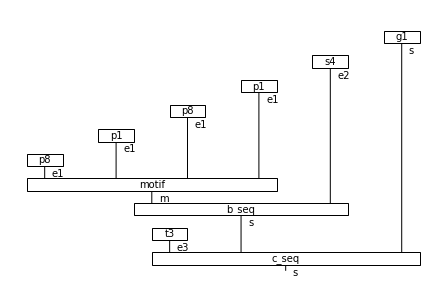

In [4]:
# 4. Parse corpus from text

from jax import numpy as np


def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[:3] == 'RIT' else [0, 1])
            sentences.append(line[3:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('datasets/music_train_data.txt')
dev_labels, dev_data = read_data('datasets/music_dev_data.txt')
test_labels, test_data = read_data('datasets/music_test_data.txt')

train_parses = [parse(sentence.split(' ')) for sentence in train_data]
dev_parses = [parse(sentence.split(' ')) for sentence in dev_data]
test_parses = [parse(sentence.split(' ')) for sentence in test_data]

print(train_data[1])
train_parses[1].draw()

In [5]:
# 5. Define functor from our musical context-free grammar to musical pregroups

from discopy import Diagram, Functor

pg_types = {
    e1: n,
    e2: (n @ n @ n @ n).r @ s,
    e3: s @ s.l @ s.l,
    s: s
}

pg_rule_reductions = {
    motif: Id(n @ n @ n @ n),
    basic_seq: Diagram.cups(n @ n @ n @ n, (n @ n @ n @ n).r) @ Id(s),
    compo_seq: Id(s) @ Diagram.cups(s.l @ s.l, s @ s)
}

def pg_reductions(ar):
    if ar in pg_rule_reductions:
        return pg_rule_reductions[ar]
    if isinstance(ar, Word):
        return Word(ar.name, pg_types[ar.cod])
    raise Exception(f"Unexpected box {ar}.")

    
cfg2pg = Functor(ob=pg_types, ar=pg_reductions)

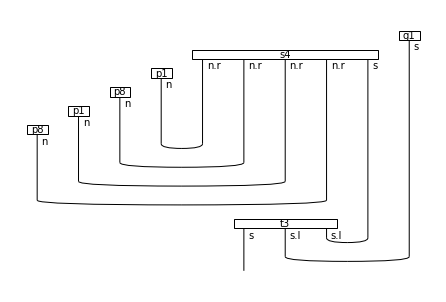

In [6]:
# 6. Convert parses into discocat diagrams

train_diagrams = [cfg2pg(parse) for parse in train_parses]
dev_diagrams = [cfg2pg(parse) for parse in dev_parses]
test_diagrams = [cfg2pg(parse) for parse in test_parses]

train_diagrams[1].draw()

In [7]:
# 7. Implements cup removal from diagrams for better performance

def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]

            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]

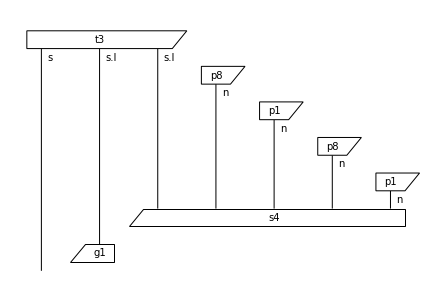

In [8]:
# 8. Remove cups from pregroup diagrams

simple_train_diagrams = [remove_cups(parse) for parse in train_diagrams]
simple_dev_diagrams = [remove_cups(parse) for parse in dev_diagrams]
simple_test_diagrams = [remove_cups(parse) for parse in test_diagrams]

simple_train_diagrams[1].draw()

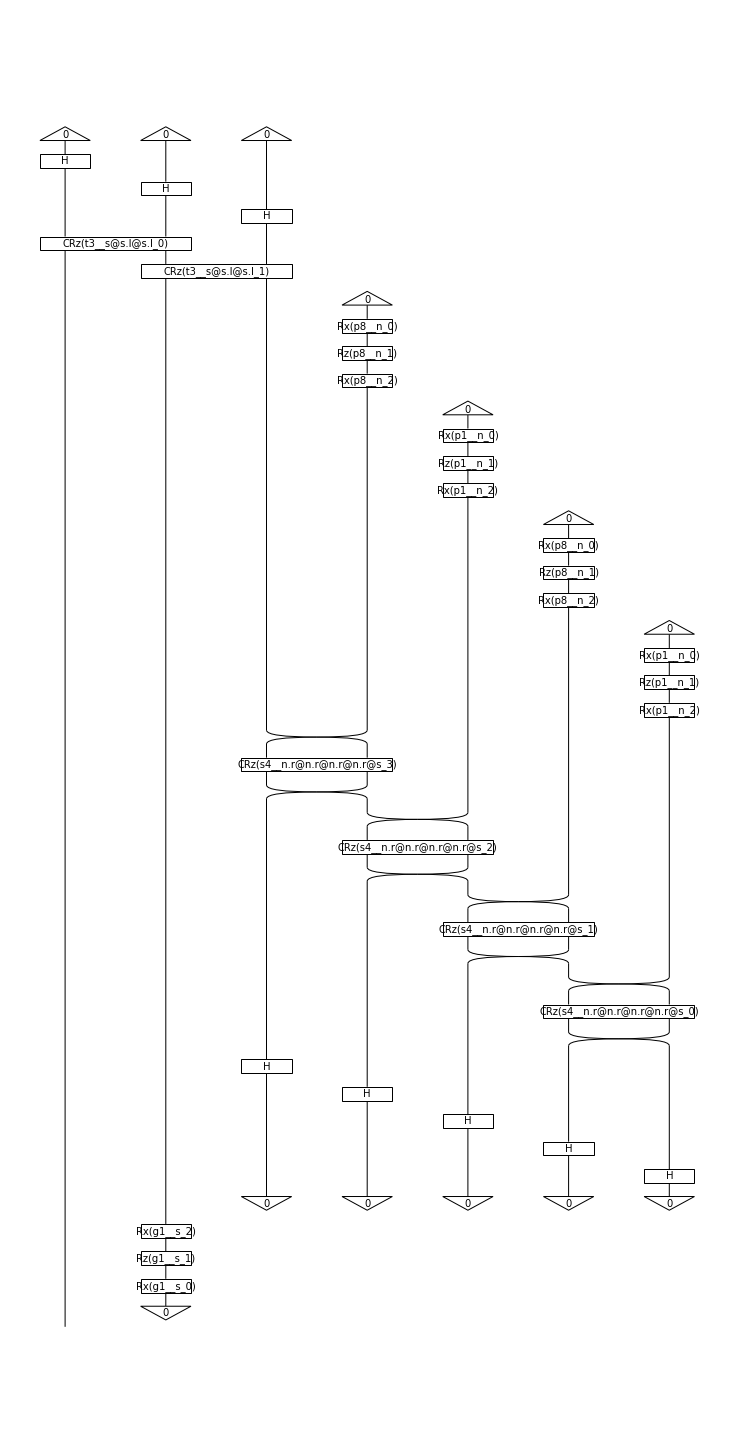

In [9]:
# 9. Use lambeq to convert rewritten diagrams to circuits

from lambeq.circuit import IQPAnsatz

ansatz = IQPAnsatz({n: 1, s: 1}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in simple_train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in simple_dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in simple_test_diagrams]

train_circuits[1].draw(figsize=(10, 20))


In [10]:
# 10. Count number of parameters in model

from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

len(parameters)

55

In [11]:
# 11. Seed experiment for reproducability
import numpy
SEED = 0
rng = numpy.random.default_rng(SEED)
x0 = np.array(rng.random(len(parameters)))
numpy.random.seed(SEED)

In [12]:
# 12. Define model and minimise loss using SPSA algorithm

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from jax import jit
from noisyopt import minimizeSPSA

Tensor.np = np


def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()


def make_pred_fn(circuits):
    circuit_fns = [c.lambdify(*parameters) for c in circuits]

    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns))
        return np.array([normalise(output.array) for output in outputs])
    return predict


train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = make_pred_fn(test_circuits)


def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(acc)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies


train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

SEED = 0
rng = numpy.random.default_rng(SEED)
x0 = np.array(rng.random(len(parameters)))
numpy.random.seed(SEED)
result = minimizeSPSA(train_cost_fn, x0=x0, a=0.2, c=0.06, niter=80, callback=dev_cost_fn)

Test accuracy: 0.76


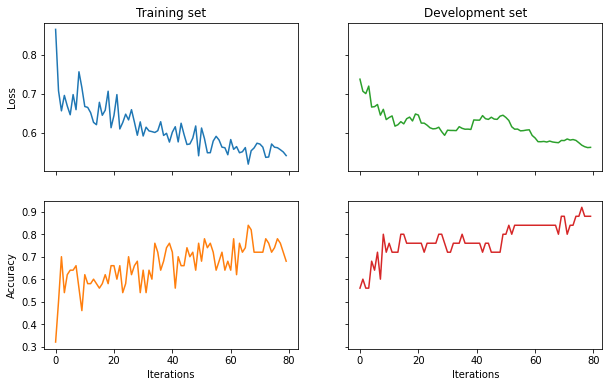

In [13]:
# 13. Plot results

import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])